# Table of Contents

#### 1. Necessary Python Imports and Setup
#### 2. Cleaning and Organizing the Data for Analysis
* Importing and Formatting
* Dropping Extra Columns
* Missing Values

#### 3. Initial Data Exploration
* Research Questions
* Initial Exploration of Date Contingency Table
* Some Toy Probability Questions


#### 4. Yearly Trends
* Yearly Trends
* Pearson Correlation Coefficient
* Hypothesis Testing for Linear Regression

#### 5. Exploration of Monthly Trends
* Quick Monthly Statistics
* A Final Visualization
* Investigating the Olympics

#### 6. Conclusions
---

# 1 Necessary Python Imports and Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import linregress

---
# 2 Cleaning and Organizing the Data for Analysis

Alright, so let's get our data in here and take a look at what we've got.

*The data comes from the Vancouver Open Data Catalogue. It was extracted on 2017-07-18 and it contains 530,652 records from 2003-01-01 to 2017-07-13.*

In [2]:
crime_df = pd.read_csv("vancouver_crime.csv")

crime_df.head()
print(crime_df.shape)

(530652, 12)


A sample of 530652 crimes in Vancouver!

*For the purposes of this project, I am going to pare down the data a little bit into something more workable. There is some great info in here, but also some extra details that I don't want to deal with while I work with the data.*

### Dropping Extra Columns
First things first, let's get rid of the X, Y, Latitude, and Longitude columns. I am satisfied with letting "Neighborhood" and "Hundred_Block" be representative of the location of the crime.

Next, there is a LOT of "time" information here.
Some of these catagories are great and useful seperately like the Year and Month of the crime.

I am less concerned about which day in the month a crime happened. I believe this is caught well enough by the month column, so I am just going to drop this "Day" column too.

Similarly, I'm less interested in where in the hour crime happened than when in the day a crime happened - I'm going to combine the Minute column into the Hour column. 



In [3]:
df = crime_df

df["HOUR"] = df.apply(
    lambda row:
        round(
            row["HOUR"] + (0.01 * row["MINUTE"] * (100/60)),
            2
        ),
    axis=1
)


df.drop(
    columns = ["X", "Y", "Latitude", "Longitude", "DAY", "MINUTE"],
    inplace = True,
)

df.head()

,TYPE,YEAR,MONTH,HOUR,HUNDRED_BLOCK,NEIGHBOURHOOD
0,Other Theft,2003,5,16.25,9XX TERMINAL AVE,Strathcona
1,Other Theft,2003,5,15.33,9XX TERMINAL AVE,Strathcona
2,Other Theft,2003,4,16.67,9XX TERMINAL AVE,Strathcona
3,Other Theft,2003,4,11.25,9XX TERMINAL AVE,Strathcona
4,Other Theft,2003,4,17.75,9XX TERMINAL AVE,Strathcona


This is looking pretty good, and very workable. 
For the sake of our later visualizations, the minutes have been converted into proportions of the full hours. The small sacrifice in readibility will be worth a smoother visualization, I think.

The last thing we are going to do is make a function to change the Months of the year back into their names, for readability. We will not use this just yet, because for now I'd still like to preserve the order of the months.

In [4]:
monthDict = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sep',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

def translate_months(df):
    """
    Takes the dataframe and changes the integer month values to text month values, returning the new dataframe.
    """
    df["MONTH"] = df.apply(
        lambda row:
            monthDict[row["MONTH"]],
        axis = 1
    )
    return df

def translate_month_columns(df):
    """
    Takes the dataframe and changes the integer month columns to text month columns, returning the dataframe.
    """
    df = df.rename(columns = monthDict)
    return df
    

This leaves us with some extremely telling variables to work with!
We have the following types of data in our study:
1. **Type** - a nominal, catagorical variable describing the type of crime committed.
2. **Year** - a nominal, ordinal variable describing the year the crime was committed.
3. **Month** - a nominal, ordinal variable describing the month of the year the crime was committed.
4. **Hour** - a discrete, numerical variable describing the minute of the day that the crime was committed.
5. **Hundred Block** - a nominal, catagorical variable describing the rough block in Vancouver the crime was committed at.
6. **Neighborhood** - a nominal, catagorical variable describing the neighborhood in Vancouver the crime was committed at.
---

### Missing Values 
Before working with the data, we need to decide on what to do with the missing values in the data frame.

In [5]:
missing_df = df.isnull().sum()

missing_df

TYPE                 0
YEAR                 0
MONTH                0
HOUR             54362
HUNDRED_BLOCK       13
NEIGHBOURHOOD    56624
dtype: int64

Since most of the missing data is in the hour and neighborhood columns, we are going to work with two situations. The first the full data frame of our sample space, with all of the crimes ( but we will only be able to use these for our calculations that do not involve the HOUR or NEIGHBORHOOD features.

The second will be the smaller subset of data that does include both the hour and neighborhood information. This will not be used for trends and calculations on year/month, but could be used on calculations about neighborhood and hour of day.

---
**NOTE:** *Initially, you can see me prepare here both subsets of data to accomplish different goals with. However, I found that I was able to do more than enough with the initial Date dataset for the purposes of this project, so the features relating to Location, Type, and Time of Day (all very exciting features), go unexplored.*

---

In [6]:
date_df = df[["TYPE", "YEAR", "MONTH", "HUNDRED_BLOCK"]].dropna()
date_df.isnull().sum()
print(date_df.shape)


(530639, 4)


In [7]:
hour_location_df = df.dropna()
hour_location_df.isnull().sum()
print(hour_location_df.shape)

(474015, 6)


For the hour_location_df, we ended up dropping about 11% of our data, which is not great.

*Unfortunately, I don't know how to clean data properly yet, and I'm not sure of the strategies to add back in the hour-of-day, which is not related to any other variables, without totally warping the averages of the HOUR variable, which is barely a numerical data type to begin with.*

Thankfully, in the context of this project, we don't even explore the location/hour/type dataset at all. Instead, have enough investigation with the Date subset alone.

---
# 3. Initial Data Exploration

## Research Questions
*Rather than approach this from trying to reproduce what I've learned in class, I instead want to approach this from research questions to answer with statistics:*

1. How does the number of crimes change year to year? Are they getting more or less frequent?
2. Which months are above average in their crime rate? Below average? How much does each month vary?
3. Did the 2010 Olympics affect the crime rate in February 2010 as compared to other years?


### Initial Explorations of Date Contingency Table
*First, let's take a look at some counts of how the months and years relate.*

In [8]:
year_df = date_df.pivot_table(
    columns = "MONTH",
    index = "YEAR",
    values = "HUNDRED_BLOCK",
    aggfunc = "count",
    margins = True,
    fill_value = 0
)

year_df.drop(index = 2017, inplace = True)


year_df = translate_month_columns(year_df)
year_df = year_df.astype("int")

year_df

MONTH,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,All
YEAR,,,,,,,,,,,,,
2003,4399,3548,3933,4214,4647,4490,4098,4281,3972,4494,3922,3928,49926
2004,3767,3697,4254,4116,4041,3862,3947,4371,4544,4479,4218,3979,49275
2005,3849,3425,3835,3806,3950,3747,3682,3861,3691,3692,3555,3568,44661
2006,3915,3262,3688,3137,3422,3591,3654,3658,3524,3584,3363,3522,42320
2007,3551,2787,3051,3076,3158,3198,3242,3635,3186,3173,2964,2671,37692
2008,2760,2829,3309,2907,3072,2989,2960,3068,2988,3078,2823,2631,35414
2009,2743,2692,2544,2533,2789,2641,2793,2907,2815,2693,2664,2358,32172
2010,2453,2245,2430,2338,2486,2444,2499,2839,2614,2751,2294,2295,29688
2011,2360,2124,2315,2148,2294,2901,2694,2489,2439,2299,2254,2256,28573


We can see here the detailed **Contingency Table** between the MONTH and YEAR variables, which lets us find some immediate insights.

* We can clearly see that the data follows what we know and is full from Jan 2003 to Dec 2016 - we have dropped 2017 because it was incomplete.
* We can clearly use this information from the table to calculate a multitude of answers for various questions we might have about the data.

### Some Toy Probability Questions:

**What is the probability that a randomly selected crime will be from 2011?**

We know that $P(a) = \frac{|a|}{|S|}$ so,
$$P(2011) = \frac{|2011|}{|S|}$$

$$P(2011) = \frac{28573}{530639}$$

$$P(2011) = 0.05384640028 $$

$$P(2011) = 5.4\% \\ $$



**What is the probability that a randomly selected crime will be in March OR from 2011?**

We know that $P(a \cup b) = P(a) + P(b) - P(a \cap b)$ so,

$$P(2011 \cup March) = P(2011) + P(March) - P(2011 \cap March) $$

$$P(2011 \cup March) = \frac{28573}{530639} + \frac{45313}{530639} - \frac{2315}{530639}$$

$$P(2011 \cup March) = \frac{71571}{530639} $$

$$P(2011 \cup March) =  0.13487700677 $$

$$P(2011 \cup March) =  13.5 \% \\ $$







**What is the probability that a crime selected from 2010 will have occured during the Vancouver Olympics (February) ?**

We know that $P(a | b) = \frac{P(a \cap b)}{P(b)}$ so,

$$ P(February | 2010) = \frac{P(February \cap 2010)}{P(2010)}$$

$$ P(February | 2010) = \frac{2245}{29688}$$

$$ P(February | 2010) = 0.07561977903 $$

$$ P(February | 2010) = 7.6 \% $$

*It should be noted this only compares Feb 2010 to the other months in 2010 - what will be more interesting is when we compare it to the February's of other years.*



# 4. Yearly Trends
*Here, we want to look at how the crime rate in Vancouver changed over the years, and use hypothesis testing to determine if there is any correlation between the year and the amount of crime in Vancouver.*

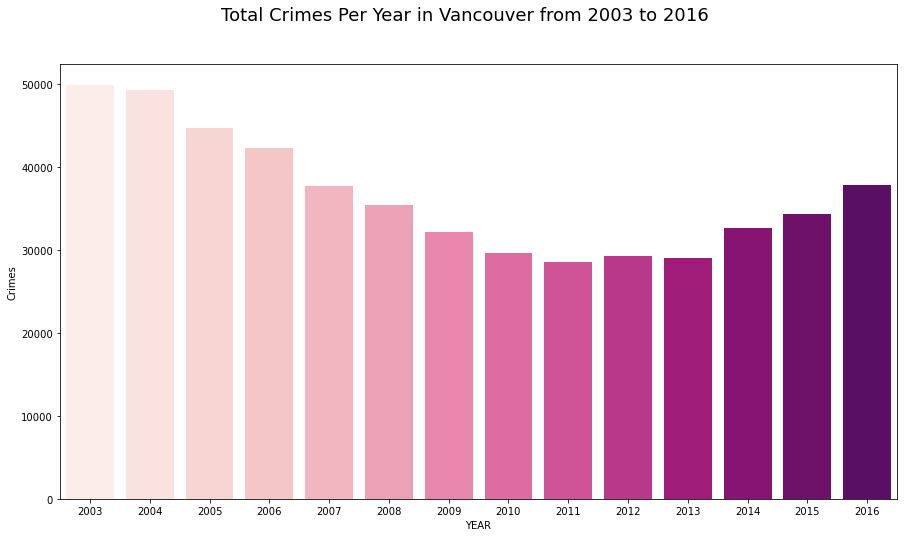

In [9]:
yearly_df = year_df["All"].drop(index = ["All"]).reset_index()
yearly_df.rename(columns = {"All" : "Crimes"}, inplace = True)

fig = plt.figure(figsize = (15, 8))
sns.barplot(
    x = "YEAR",
    y = "Crimes",
    data = yearly_df,
    palette = "RdPu"
    )
fig.suptitle(
    "Total Crimes Per Year in Vancouver from 2003 to 2016",
    fontsize = 18
)
plt.show()

Indeed, it does appear at first as if there is some decrease in crime through the years!

Let's look to see how "linear" the data actually is.

### Pearson Correlation Coefficient

Here we will use our formula for the Sample Correlation Coeffiecent, using our Yearly Count as $x$ and our Year as $y$. The formula is as follows: 

$$ r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{n(\sum x^2) - (\sum x)^2}\sqrt{n(\sum y^2) - (\sum y)^2}} $$

This variable $r$ is a measure of how "linear" the graph is. For data that is completely non-linear, $r$ will be 0, and as the data becomes more linear, $r$ will approach either $1$ or $-1$.

In [10]:
slope, intercept, r, p, error = linregress(
    yearly_df["YEAR"],
    yearly_df["Crimes"]
)
print("r =", r)

r = -0.7351058405054328


We can see that the correlation coefficient $r = -0.735106$, which seems to indicate some sort of linearity. However, that is only true for our sample here - we still need to make some conclusions about the population.

### Hypothesis Testing for Regression

Let the **null hypothesis** be that the year has no affect on the number of crimes, and the **alternative hypothesis** be that there is a linear relationship between them.

In other words:
$$ H_0 : \rho = 0 \\ H_A : \rho \ne 0 $$

We can use this $r$ to calculate $p$, using a t distribution with the following critical values:

$$ t_{calc} = r\sqrt{\frac{n -2}{1 - r^2}} $$

Here, $n = 530639$, since we have that many samples.

With that in mind, we can calculate those $t$-values, and lookup a t table to find our level of $p$ for us to compare to.

*Since we are using python, I used a scipy library to do the calculations.*

In [11]:
print("p =", p)

p = 0.002740146309214047


We can see here that $p = 0.002740146309214047$. 

Since we do not have any special circumstances, we can move forward comparing it to our default 95% confidence rate with $\alpha = 0.05$.

We see here that $$ 0.0027 < 0.0500 $$
 $$ p < \alpha $$

And therefore we know that it is very unlikely for us to have found this data given that the null hypothesis was true. Instead, we can safely reject the null hypothesis, and conclude that **there is indeed correllation between the Year and the number of crimes.**

*This could be to any sort of real world factors - infrastructure changes over time, political decisions, cultural value placed on or against policing, moral changes in Vancouver, etc.*

Let's take a look at what that line might look like against our yearly data.

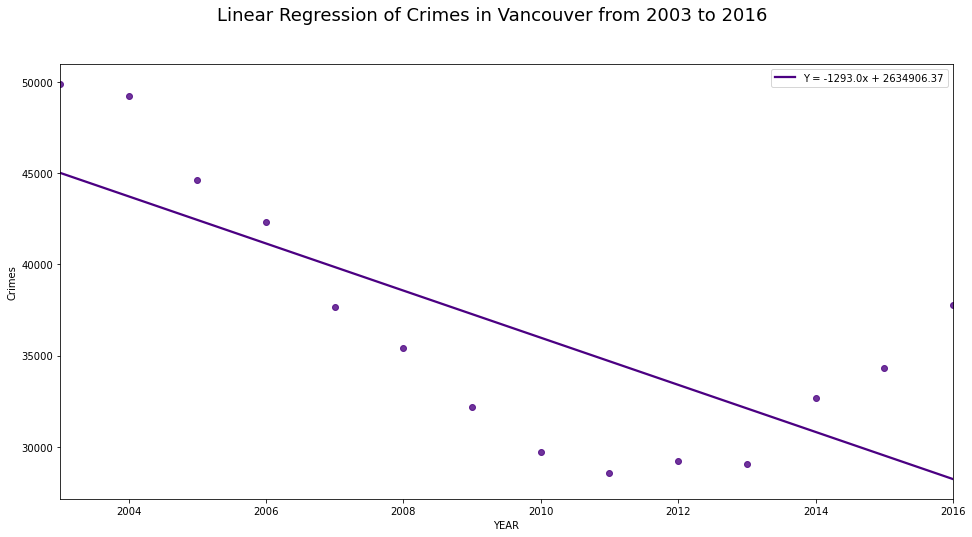

In [21]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.regplot(
    x = "YEAR",
    y = "Crimes",
    data = yearly_df,
    ci = None,
    color = "indigo"
    )
ax.legend([f"Y = {round(slope, 2)}x + {round(intercept, 2)}"])
fig.suptitle(
    "Linear Regression of Crimes in Vancouver from 2003 to 2016",
    fontsize = 18
)

plt.show()

Visually, we can plainly see that our line does not catch all the details of the trends in yearly crimes. In this class, we used only a strictly linear test, while the data can be clearly seen to increase after 2013, which our data does not catch. 

While it is true that our Date has correlation with the number of crimes, it would be foolish to not mention that most of the decrease happens from 2004-2011, with the trend significantly changing direction after then.

This can be seen if we calculate the **Coefficient of Determination** with : $$ R^2 = (r)^2 \\ = (-0.7351058405054328)^2 \\ = 0.54038059674 $$

This means that $ 54 \%$ of the variance of the data is NOT accounted for by our linear equation. This is not the ideal model for our sample. Still, the hypothesis testing was useful, and the visualization helps us understand our data better.

---

# 5. Exploration of Monthly Trends

*Here we will be examining which months, if any, are the worst and best for crime. Then, we hope to answer our research question - did the Olympics affect the crime rate in Vancouver while it was here?*

### Quick Monthly Statistics:

The mean, calculated as follows, is a mathematical representation of the average outcome of a variable.

$$ \bar x = \frac{\sum_{i=1}^n x_i}{n-1}$$

We can use this calculation for each of the months in the year, in order to find the average number of crimes for each month in the year, as calculated from the 2003 - 2016 sample. 

In [13]:
month_mean_df = year_df.drop(index = "All").mean().reset_index().set_index("MONTH")
month_mean_df.rename(columns = {0 : "Mean Monthly Crimes"}, inplace = True)
month_mean_df.drop(index = "All", inplace = True)

month_mean_df

,Mean Monthly Crimes
MONTH,
Jan,3053.500000
Feb,2717.857143
Mar,3022.428571
Apr,2941.142857
May,3133.928571
Jun,3129.928571
Jul,3173.357143
Aug,3281.642857
Sep,3125.000000


Here we can see that the lowest average rate of crime is in February with 2717.9 crimes on average, and the highest is in August with 2381.6 crimes on average, and all of the other months fall in between.

It might be useful to quickly see these means visually, so here is a bar plot.

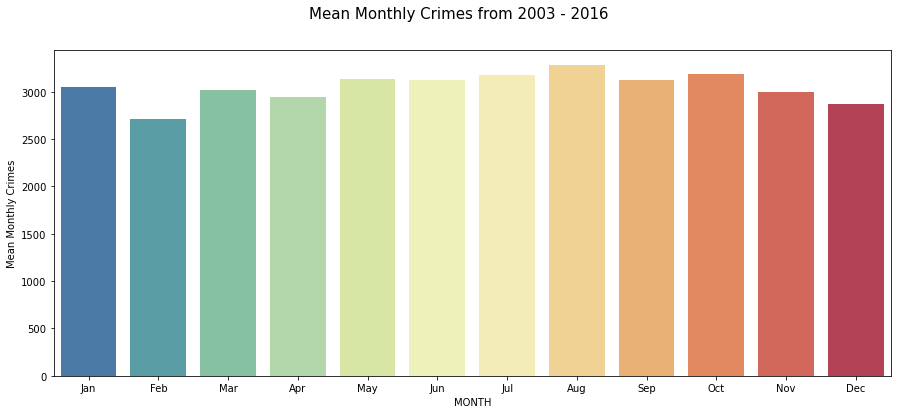

In [14]:
month_mean_df.reset_index(inplace = True)

f, axes = plt.subplots(figsize = (15,6))

sns.barplot(
    x = "MONTH",
    y = "Mean Monthly Crimes",
    data = month_mean_df,
    palette = "Spectral_r"
)
f.suptitle(
    "Mean Monthly Crimes from 2003 - 2016",
    fontsize = 15
)
plt.show()


It is hard to gain insights from this alone, but it initially looks like it points towards a trend of a higher crime rate in the summer months, and a lower rate in winter months - with January being the exception. February has the lowest mean.

---

Another useful thing to consider would be finding out how much each month might vary across the years.
Mathematically, we can find this by using the **Variance** and the **Standard Deviation**.

The Variance, calculated as follows, is a measurement of how much the value of the data set would vary from it's mean. 

$$ S^2 = \frac{\sum_{i=1}^n (x_i - \bar x)^2 }{n - 1}$$

Then, to find the Standard Deviation, we simply find the square root of the variance.

$$ S = \sqrt{S^2} $$

Since we already have the average values for each month, we can easily calculate the variance and standard deviation of each individual month and how much it varies through the years. 

We are going to find out how volitile and prone to change each month is, and use that in tandem with our calculated monthly means to get an idea about the data.

In [15]:
month_std_df = year_df.drop(index = "All").std().reset_index().set_index("MONTH")
month_std_df.rename(columns = {0 : "Standard Deviation of Monthly Crimes"}, inplace = True)
month_std_df.drop(index = "All", inplace = True)
month_std_df.reset_index(inplace = True)

month_stat_df = month_mean_df.merge(
    month_std_df,
    how = "left",
    on = "MONTH",
)
month_stat_df.set_index("MONTH", inplace = True)

month_stat_df

,Mean Monthly Crimes,Standard Deviation of Monthly Crimes
MONTH,,
Jan,3053.500000,730.611835
Feb,2717.857143,585.653331
Mar,3022.428571,682.176011
Apr,2941.142857,676.894476
May,3133.928571,702.566664
Jun,3129.928571,613.122709
Jul,3173.357143,547.154402
Aug,3281.642857,598.962257
Sep,3125.000000,614.225216


There are a couple conclusions we might take away from this:
* January and May seem quite average when viewing only their mean, but here we can see they have the most variation of all of the months. Perhaps some single events over the years could have contributed to more outliers for those months?

* August, while having the highest mean crime rate, also has a fairly small Standard Deviation. This needs more testing, but could indicate that it is consistantly a crime-ridden month.

* February, while having the fewest average crimes, also has the one of the smallest standard deviation. This means that according to our dataset, February might be pretty consistantly the safest month of the year. 



Let's look further into a comparison of our monthly statistics side by side, using a **Box Plot**. This will let us compare their averages and spread of the data further, using a positional calculation of average with the **median** and of spread using **IQR**.





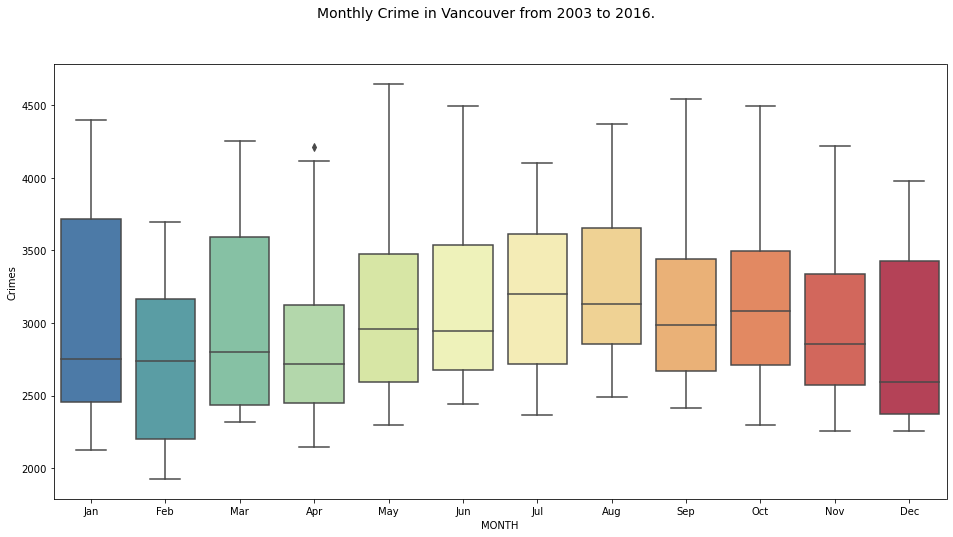

In [16]:
year_vis_df = date_df.groupby(["YEAR", "MONTH"]).count()
year_vis_df.drop(columns = "HUNDRED_BLOCK", inplace = True)
year_vis_df.rename(columns = {"TYPE" : "Crimes"}, inplace = True)
year_vis_df = year_vis_df.drop(index = 2017).reset_index()
year_vis_df = translate_months(year_vis_df)
year_vis_df["YEAR"] = year_vis_df["YEAR"].astype(str)

f, axes = plt.subplots(figsize = (16, 8))

f.suptitle(
    "Monthly Crime in Vancouver from 2003 to 2016.",
    fontsize = 14)

sns.boxplot(
    x = "MONTH",
    y = "Crimes",
    data = year_vis_df,
    palette = "Spectral_r"
)
plt.show()

This boxplot gives us more insight into our monthly trends. 

If we examine just the boxes, we can see that our small hypothesis about summer months tending to have more crime seems to be supported - however, January and March too do not seem to follow this outside of their median.

While at first it seemed that February may have consistantly been the month with the least crime, here we can April is also an unusual case: it has a low median, and a small IQR, but is largely left skewed with even an outlier appearing.

This can be proven further by examining the Statistics of April.
We can see above it has a mean of about 2941 crimes, while in the boxplot we can see visually that the median is only around 2700.

Since $$ \bar x > \text{Median}$$

We can mathematically conclude that April's data is significantly **right-skewed**. We see this visually on our box-plot.



### A Final Visualization

This may help visualize a comparison of the different crime counts throughout the years.

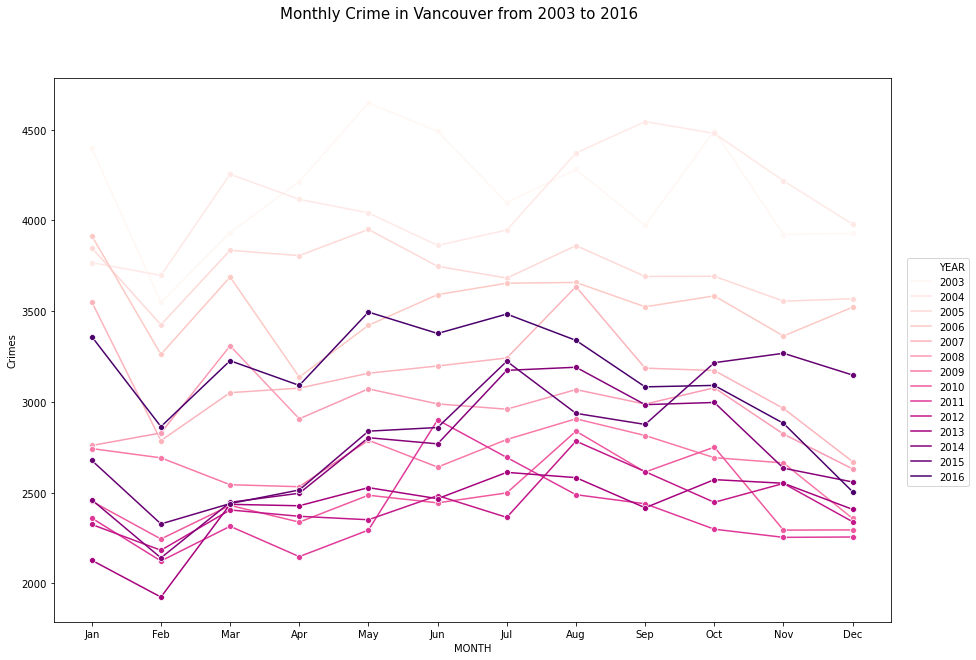

In [17]:
year_vis_df = date_df.groupby(["YEAR", "MONTH"]).count()
year_vis_df.drop(columns = "HUNDRED_BLOCK", inplace = True)
year_vis_df.rename(columns = {"TYPE" : "Crimes"}, inplace = True)
year_vis_df.drop(index = 2017, inplace = True)
year_vis_df.reset_index(inplace = True)
translate_months(year_vis_df)

fig, axes = plt.subplots(figsize = (15, 10))
sns.lineplot(
    x = "MONTH",
    y = "Crimes",
    hue = "YEAR",
    data = year_vis_df,
    sort = False,
    legend = "full",
    palette = "RdPu",
    marker = "o"
)

plt.legend(
    bbox_to_anchor=(1.02, 0.25),
    loc=3,
    borderaxespad=0.)

fig.suptitle(
    "Monthly Crime in Vancouver from 2003 to 2016",
    fontsize = 15
)

plt.show()

Initially I put together this visualization in hopes to compare some trends across the months. Indeed, we can see that there is a small dip in all the Februraries and Decembers that come up, as well as an upward trend going into many Augusts.

April can indeed be seen mostly concentrated right around 2500 crimes, with a few exceptions in the earlier years, explaining our tight concentration (and left skew).

This visualization also helps to show some unusual months in relation to the rest of their year. Our small prediction towards the fall's high standard deviation may haved proved true we can see a clear outlier in September 2004 of a strange amount of crimes. We also see a similar outlier in May of 2003.

This visualization only serves to cement further our conclusions on yearly trends: Vancouver seems to be improving over the years until around 2011, then begins to get worse from there.

### Investigating the Olympics

In this section, we will examine if the 2010 olympics had any affect on the rate of crime in Vancouver. For simplicity's sake, we will be defining the entire month of February 2010 as the olympics.

Let us review what we already know about February's in general:

In [18]:
month_stat_df.loc[["Feb"]]

,Mean Monthly Crimes,Standard Deviation of Monthly Crimes
MONTH,,
Feb,2717.857143,585.653331


Now to compare, what was our number of crimes for February of 2010?

Let's check our contingency table we made to be sure.

In [19]:
print("Crimes in Feb 2010 =", year_df.at[2010, "Feb"])

Crimes in Feb 2010 = 2245


Indeed, it appears as if our 2010 value for February is in fact well below the mean - almost one full standard deviation below. 

It's difficult to make a conclusive hypothesis test about this since we are using just one value of one month of February - how could we account for any randomness at all?

What we can do, is estimate the true $\mu$ of the mean crime rate in any February. We have a good idea of what it could be with our data over this 14 year sample, but we need to create a **confidence interval** to know just how inaccurate we may be.

Our population here is the crime of all Februaries in Vancouver. Since we do not know the population standard deviation, we can use the standard deviation of our sample noted above to work with a **T Distribution**.

This interval we are creating can be found using the following formula:

$$ \bar x - t_{\frac{\alpha}{2}}\frac{s}{\sqrt n} \quad \le \ \mu \ \le \quad \bar x + t_{\frac{\alpha}{2}}\frac{s}{\sqrt n} $$

In our case, we know already from our sample that $n = 14$, that  $\bar x = 2717.857143$, and that $S_x = 585.653331$. We have no reason to adjust our default confidence level of $c = 0.95$, so $\frac \alpha 2 = 1 - c = 0.05 $

Upon consulting a t-table, we can find that our t value for $c=0.95$ works out to be $t= 1.96$. Let's calculate this:

In [20]:
feb_data = year_df["Feb"].drop(index="All").to_list()

sms.DescrStatsW(feb_data).tconfint_mean()

(2379.7109768197174, 3056.003308894568)

So it seems like we can be 95% confident that our $\mu$ for monthly crime in February is within the interval:
$$ \mu \in (2379.81, 3056.00)$$


...but unfortunately, there is a problem. Our sample data is NOT a **normal distribution**. That means that the t-distribution we modeled with is simply innacurate. 

We have some hope using the **Central Limit Theorem**, and arguing that the average values of our sample model a Normal Distribution with:

$$\bar X \approx N(\mu, \frac{\sigma}{\sqrt n}) $$

But that isn't entirely true either, since our sample is only of 14 different Februaries, which is pretty small. ($n < 30$)

As a result, we cannot trust our confidence interval here for the mean of February Crime in Vancouver. 

---

*This section has been kept in this project simply as a proof of concept to touch on class materials. I still wanted to work with confidence intervals and make reasonable conclusions with them*. 

---

If it was true, we could be reasonably sure that February 2010 reported a below average crime rate - and make some predictions that this was due to the 2010 olympics that were present. 

However, it should be noted that February 2010 is still not officially an **outlier** in our sample, as reported in the boxplot above.

With all this information, it remains inconclusive definitely if the 2010 Olympics made an impact on the crime rate in Vancouver while they were here.

---

# 6. Final Thoughts

*With all this data and summaries, I wanted to mention the various things we investigated in this project:*


### Conclusions
*We conclusively proved these with hypothesis testing*

* There is indeed a negative correlation between Year and Amount of Crime in Vancouver. This indicates that our city may be seeing less crime as time goes on, which is a positive thing. However, our linear model only accounted for 54% of the trends, and we could see visually that things seemed to get better, and then worse after 2013.

### Hypothetical Trends
*We observed some general trends in statistics and posed some possible explanations*

* It seems like summer months, especially August, are the worst months for Crime in Vancouver.
* It seems like February in general may be the least crime-filled month in Vancouver.
* While in the past April saw plenty of crime, it seems to have since stabilized to a low crime-rate.
* It seems that February of 2010 was below average in crime rate, but it remains unanswered if this is statistically significant.


### Further Studies
*We only looked at trends in DATE from our dataset. There are plenty more questions that could be answered by bringing in some other variables, like Location or Type of Crime:*

1. Are certain crimes more common at a certain time of day? Is there any correlation between the rate of a certain crime and the time of day?
2. Which neigborhoods have the least reported crimes? Which have the most? Has that changed over the years?
3. Given a type of crime and the time of day, can we predict what neighborhood it occured in?

